## Init

In [4]:
data_path= "../data/uji/"

In [5]:
import base64, collections, io, itertools, functools, json, os, random, re, textwrap, time, urllib
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from IPython import display
from six.moves.urllib import request
from xml.dom import minidom
import string

from __future__ import division


In [7]:
# After executing the cell above, Drive
# files will be present in "/content/drive/My Drive".
!ls "../data/uji/"

uji2.names	   ujipenchars2.txt	 ujipenchars_set.ndjson
ujipenchars2.json  ujipenchars_set.json


## Get the data

In [8]:
with open(data_path+"ujipenchars2.txt") as f:
    content = f.readlines()
charList = list(string.ascii_letters)
#charList = ['l','L','o','O','A','a','b','B','c','C']

In [9]:
def parseUJIPEN(content,charList):
  '''
  Take file content and parse all instances of characters in charList 
  '''
  currentCharacter = None
  strokesLeft = 0
  currentDigit = []
  trainLibrary = {}
  testLibrary = {}
  writerCharacterCount = 0
  
  for line in content:
    
    if line.startswith('// ASCII char: '):
      newChar = line[len('// ASCII char: ')]
      if newChar in charList:
        currentCharacter  = newChar
        writerCharacterCount += 1
        continue
      currentCharacter = None
      continue
    
    if currentCharacter != None:
      
      if line.startswith('  NUMSTROKES '):
        strokesLeft = int(line[len('  NUMSTROKES ')])
        continue
      
      if line.startswith('  POINTS '):
        splitLine = line.split(' ')
        #print("Stroke has points: " + splitLine[3])
        allCoordinates = splitLine[5:]
        stroke = []
        it = iter(allCoordinates)
        
        while True:
          xString = next(it, None)
          yString = next(it, None)
          
          if xString == None or yString == None:
            break
          
          stroke.append( [int(xString), int(yString)] )
        
        currentDigit.append(stroke)
        strokesLeft -= 1
        if strokesLeft == 0:
          # Add it to the library
          
          theLibrary = trainLibrary
          
          existingSamples = theLibrary.get(currentCharacter, None)
          if existingSamples != None:
            existingSamples.append(currentDigit)
          else:
            theLibrary[currentCharacter] = [currentDigit]
          
          currentDigit = []
  return trainLibrary
  

In [10]:
df = parseUJIPEN(content,charList)
df.keys()

dict_keys(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'])

In [11]:
def plotGradient(x,y,MAP='plasma' ):
    plt.title('Simple plot')
    
    cm = plt.get_cmap(MAP)
    #plt.set_color_cycle([cm(1.*i/(len(x)-1)) for i in range(len(x)-1)])
    for i in range(len(x)-1):
        plt.plot(x[i:i+2],y[i:i+2])

    #fig.savefig('gradColorLine.png')
    plt.show()

2


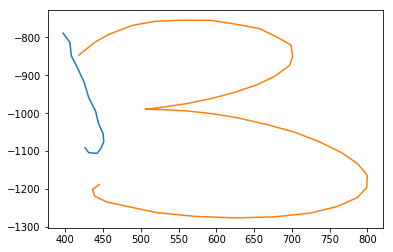

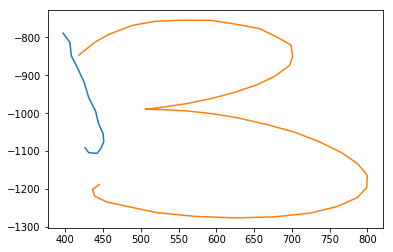

In [12]:
test = df['B'][24]
print(len(test))

def findMinMax(letter): 
  xmin = min([row[0] for row in letter[0]])
  ymin = min([row[1] for row in letter[0]])
  xmax = max([row[0] for row in letter[0]])
  ymax = max([row[1] for row in letter[0]])
  for i in range(1,len(letter)): # for each stroke
    x = [row[0] for row in letter[i]]
    y = [row[1] for row in letter[i]]
    
    if min(x) < xmin : xmin = min(x) 
    if max(x) > xmax : xmax = max(x) 
    if min(y) < ymin : ymin = min(y) 
    if max(y) > ymax : ymax = max(y)
  return {'xmin':xmin,'xmax':xmax,'ymin':ymin,'ymax':ymax}
  

def rescale(letter):
  scaled_letter = [] 
  minmax = findMinMax(letter)
  #print(minmax)
  for i in range(0,len(letter)): # for each stroke
    x = [row[0] for row in letter[i]]
    y = [row[1] for row in letter[i]]
    
    #x = [(i - minmax['xmin'])/ (minmax['xmax']- minmax['xmin'])   for i in x]
    #y = [(j - minmax['ymin'])/ (minmax['ymax']- minmax['ymin'])  for j in y]
    
    row = list(zip(x,y))
    scaled_letter.append(row)
  
  return scaled_letter

def plotLetter(letter):
  for i in range(0,len(letter)):
    x = [row[0] for row in letter[i]]
    y = [row[1] for row in letter[i]]
    plt.plot(x,y)
def plotLetterRight(letter):
  for i in range(0,len(letter)):
    x = [row[0] for row in letter[i]]
    y = [row[1] for row in letter[i]]
    plt.plot(np.array(x),-np.array(y))

plt.figure(0) 
plotLetterRight(test)

test_sc = rescale(test)
plt.figure(1)
plotLetterRight(test_sc)

## Save the scaled dataset

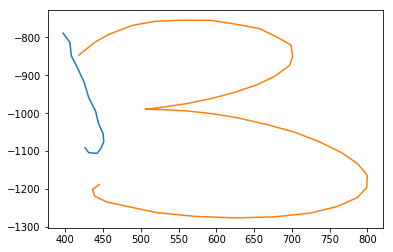

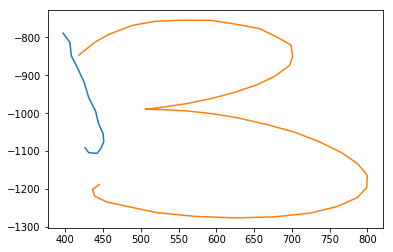

In [13]:
test = df['B'][24]
plt.figure(0) 
plotLetterRight(test)

for k in df.keys(): 
  for i in range(0,len(df[k])):
    sample  = df[k][i]
    df[k][i] = rescale(sample)
    
    
test = df['B'][24]
plt.figure(1) 
plotLetterRight(test)



In [14]:
##### Save letters in same format as quickdraw drwaings

filename = data_path+"/ujipenchars_set.ndjson"
with open(filename, "wt") as fp:
    
  for k in df.keys():
    for i in range(0,len(df[k])):
      sample  = df[k][i]
      d_sample = {'letter':k,'nb_stroke':len(sample),'l_id':k+str(i),"drawing":sample}
      json.dump(d_sample, fp)
      fp.write('\n')

    
  


In [16]:
### save letters in individual files
for k in df.keys():
  filename = data_path+"/no_scale/"+k+".ndjson"
  with open(filename, "wt") as fp:
    for i in range(0,len(df[k])):
      sample  = df[k][i]
      d_sample = {'letter':k,'nb_stroke':len(sample),'l_id':k+str(i),"drawing":sample}
      json.dump(d_sample, fp)
      fp.write('\n')

In [17]:
### save strokes in individual files
for k in df.keys():
  filename = data_path+"no_scale/strokes/"+k+".ndjson"
  with open(filename, "wt") as fp:
    for i in range(0,len(df[k])):
      sample  = df[k][i]
      d_sample = {'letter':k,'nb_stroke':len(sample),'l_id':k+str(i),"drawing":sample}
      for si in range(d_sample['nb_stroke']): 
        ll=list()
        x = [row[0] for row in d_sample['drawing'][si]]
        y = [row[1] for row in d_sample['drawing'][si]]
        ll.append(x)
        ll.append(y)
        row = {'letter':d_sample['letter'], 'l_id':d_sample['l_id'], 'nb_stroke':d_sample['nb_stroke'],'stroke_order':si,'stroke':ll,'keyid':d_sample['l_id']+'_'+str(si)}
        json.dump(row, fp)
        fp.write('\n')

In [21]:
path = filename

data_json = json.loads(tf.gfile.Open(path).readline())
data_json.keys()

dict_keys(['letter', 'l_id', 'nb_stroke', 'stroke_order', 'stroke', 'keyid'])

In [22]:
plotLetter(data_json['stroke'])

TypeError: 'int' object is not subscriptable

## plotting utils
This following block create function to color with a gradient

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll


def multicolored_lines(x,y,cmap='winter'):
    """
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    """

    fig, ax = plt.subplots()
    lc = colorline(x, y, cmap=cmap)
    plt.colorbar(lc)
    plt.xlim(min(x), max(x))
    plt.ylim(-1.0, 1.0)
    plt.show()

def colorline(
        x, y, z=None, cmap='copper', norm=plt.Normalize(0.0, 1.0),
        linewidth=3, alpha=1.0):
    """
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    """

    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))

    # Special case if a single number:
    # to check for numerical input -- this is a hack
    if not hasattr(z, "__iter__"):
        z = np.array([z])

    z = np.asarray(z)

    segments = make_segments(x, y)
    lc = mcoll.LineCollection(segments, array=z, cmap=cmap, norm=norm,
                              linewidth=linewidth, alpha=alpha)

    ax = plt.gca()
    ax.add_collection(lc)

    return lc

def make_segments(x, y):
    """
    Create list of line segments from x and y coordinates, in the correct format
    for LineCollection: an array of the form numlines x (points per line) x 2 (x
    and y) array
    """

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments

